<a href="https://colab.research.google.com/github/FranciscoGlez25/CNN-TC/blob/main/VGG16_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuración Inicial y Bibliotecas de PyTorch**

En este bloque de código, se realiza la configuración inicial del entorno para trabajar con modelos de aprendizaje profundo utilizando la biblioteca PyTorch.

1. **Importación de Bibliotecas:**
   - Se importan diversas bibliotecas y módulos necesarios para la construcción y evaluación de modelos de aprendizaje profundo. Entre estas se encuentran Torchvision para herramientas de visión por computadora, Matplotlib y Seaborn para visualización de datos, y diversas utilidades de PyTorch.

2. **Verificación de Disponibilidad de GPU:**
   - Se utiliza `torch.cuda.is_available()` para determinar si una GPU está disponible. Si está disponible, el dispositivo de entrenamiento se establece en 'cuda'; de lo contrario, se utiliza la CPU.

3. **Definición de Transformaciones y Optimizador:**
   - Se importan clases y funciones específicas de PyTorch para transformaciones de datos, optimización y definición de modelos. Estas incluyen transformaciones de imágenes, el optimizador Adam, y funciones de inicialización de pesos.

4. **Definición de Clases y Funciones Útiles:**
   - Se definen clases como `Dataset` y `DataLoader` para gestionar conjuntos de datos, y varias funciones para calcular métricas de evaluación como la matriz de confusión, el informe de clasificación y puntajes de precisión, recuperación y F1.

5. **Configuración del Entorno de Visualización:**
   - Se configuran herramientas de visualización como Matplotlib y Seaborn para crear gráficos y mapas de calor. Esto incluye la configuración de un dispositivo de visualización utilizando `plt.show()`.

Este bloque establece las bases para la manipulación de datos, entrenamiento de modelos y evaluación de rendimiento en el contexto de aprendizaje profundo con PyTorch. La verificación de la disponibilidad de la GPU es particularmente útil para aprovechar el rendimiento acelerado en hardware compatible.

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as img
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.nn import Linear, CrossEntropyLoss, Sequential

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# **Definición de Transformaciones de Imágenes**

En este bloque de código, se definen las transformaciones necesarias para el preprocesamiento de imágenes. Estas transformaciones son esenciales para alimentar efectivamente las imágenes a un modelo de aprendizaje profundo.

1. **transform_train:** Se utiliza para el conjunto de entrenamiento y consta de las siguientes operaciones:
    - `ToTensor()`: Convierte la imagen a un tensor.
    - `Resize(size=(224, 224))`: Ajusta el tamaño de la imagen a (224, 224).
    - `RandomHorizontalFlip(p=0.5)`: Aplica una rotación horizontal aleatoria con una probabilidad del 50%.
    - `Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza los valores de píxeles de la imagen según la media y la desviación estándar proporcionadas.

2. **transform_test:** Se utiliza para el conjunto de prueba y consta de las siguientes operaciones:
    - `ToTensor()`: Convierte la imagen a un tensor.
    - `Resize(size=(224, 224))`: Ajusta el tamaño de la imagen a (224, 224).
    - `Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normaliza los valores de píxeles de la imagen según la media y la desviación estándar proporcionadas.

Estas transformaciones garantizan que las imágenes se encuentren en un formato adecuado y estandarizado antes de ser utilizadas para el entrenamiento y la evaluación del modelo. Además, las transformaciones de entrenamiento incluyen operaciones de aumento de datos, como la rotación horizontal aleatoria, para mejorar la capacidad del modelo para generalizar a nuevas imágenes.

In [ ]:
from torchvision import datasets, transforms, models

# Definir transformaciones para el preprocesamiento de las imágenes
transform_train = v2.Compose([v2.ToTensor(),
                    v2.Resize(size = (224, 224)),
                    v2.RandomHorizontalFlip(p=0.5),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

transform_test = v2.Compose([v2.ToTensor(),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# **Definición de Conjunto de Datos Personalizado para Clasificación de Imágenes**

El siguiente bloque de código define una clase llamada `CustomDataset` que hereda de la clase `Dataset` de PyTorch. Esta clase personalizada se utiliza para cargar imágenes y etiquetas desde un archivo CSV.

1. **Método `__init__`:**
   - Se inicializa la clase con tres parámetros:
      - `csv_file`: Ruta al archivo CSV que contiene información sobre las imágenes y sus etiquetas.
      - `root_dir`: Ruta al directorio que contiene las imágenes.
      - `transform`: Transformaciones a aplicar a las imágenes (puede ser `None` si no se desean transformaciones).

2. **Carga de Anotaciones y Número de Clases:**
   - Las anotaciones se cargan desde el archivo CSV utilizando `pd.read_csv` y se almacenan en el atributo `annotations`.
   - Se calcula el número de clases únicas en la columna 'Egreso' del conjunto de datos y se almacena en `num_classes`.

3. **Método `__len__`:**
   - Devuelve la longitud total del conjunto de datos, que es la cantidad de filas en el archivo CSV.

4. **Método `__getitem__`:**
   - Obtiene la ruta de la imagen y la etiqueta correspondiente para el índice dado.
   - Abre la imagen en formato RGB utilizando `Image.open`.
   - Si se proporciona una transformación (`transform` no es `None`), aplica las transformaciones a la imagen.
   - Devuelve la imagen transformada y la etiqueta asociada.

Este conjunto de datos personalizado es útil cuando se trabaja con datos almacenados en una estructura específica y se desea aplicar transformaciones personalizadas a las imágenes. Además, la clase se integra con las funcionalidades de carga de datos de PyTorch, como `DataLoader`.

In [ ]:
# Definir dataset personalizado para cargar imágenes y clases desde archivos CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Obtener el número de clases desde el conjunto de datos
        self.num_classes = len(self.annotations['Egreso'].unique())  # Suponiendo que la columna de etiquetas se llama 'label'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.annotations.iloc[index, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Montaje de Google Drive en Colab**

En este bloque de código, se utiliza la biblioteca `google.colab` para montar Google Drive en el entorno de ejecución de Google Colab. Google Drive es una plataforma de almacenamiento en la nube, y montarlo en Colab permite acceder y manipular archivos almacenados en Google Drive directamente desde el entorno de ejecución.

1. **Importación de la Biblioteca:**
   Se importa la biblioteca `drive` desde `google.colab`.

2. **Montaje de Google Drive:**
   La función `drive.mount('/content/drive')` se utiliza para montar Google Drive en el directorio `/content/drive` de Colab. Al ejecutar esta celda, aparecerá un enlace para autorizar el acceso a Google Drive. Después de la autorización, se generará un código de autenticación que debe ser copiado y pegado en un campo de entrada en la celda para completar el proceso de montaje.

Este bloque es esencial cuando se trabaja con archivos almacenados en Google Drive desde un entorno de ejecución en Google Colab. Una vez montado, se pueden acceder a los archivos de Google Drive como si fueran archivos locales en la ruta `/content/drive`.

In [ ]:
from google.colab import drive

# Monta Google Drive en el entorno de ejecución
drive.mount('/content/drive')

# **Creación y Descripción del Conjunto de Datos de Entrenamiento**

En este bloque de código, se realiza lo siguiente:

1. **Definición del Conjunto de Datos de Entrenamiento:**
   - Se crea una instancia del conjunto de datos personalizado `CustomDataset` para el conjunto de entrenamiento.
   - La ruta al archivo CSV (`'ruta_archivo_csv'`), la ruta al directorio de imágenes (`'ruta_carpeta_imagenes'`), y las transformaciones (`transform_train`) se proporcionan como parámetros.
   
2. **Obtención de la Cantidad Total de Imágenes en el Conjunto de Entrenamiento:**
   - La longitud total del conjunto de entrenamiento se obtiene utilizando la función `len(train_dataset)`.
   - Se imprime la cantidad total de imágenes en el conjunto de entrenamiento.

Este bloque de código es esencial para cargar y entender la cantidad de datos disponibles en el conjunto de entrenamiento. La información recopilada aquí será útil para ajustar parámetros y realizar un seguimiento del rendimiento del modelo durante el entrenamiento.

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define el conjunto de datos completo
train_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_train)

total_train = len(train_dataset)
print(f'Cantidad total de imágenes en Train Dataset: {total_train}')

Cantidad total de imágenes en Train Dataset: 964


# **División del Conjunto de Datos en Entrenamiento y Validación**


En este bloque de código, se lleva a cabo la partición del conjunto de datos en entrenamiento y validación, junto con la definición de los `DataLoaders` correspondientes.

1. **Obtención del Número Total de Muestras:**
   - Se calcula el número total de muestras en el conjunto de entrenamiento usando `len(train_dataset)` y se almacena en la variable `total_samples`.

2. **Cálculo del Tamaño del Conjunto de Validación:**
   - Se define el porcentaje de datos destinados al conjunto de validación mediante `validation_split` (por ejemplo, 20%).
   - Se calcula el tamaño del conjunto de validación (`validation_size`) como un porcentaje del número total de muestras.

3. **Cálculo del Tamaño del Conjunto de Entrenamiento:**
   - Se calcula el tamaño del conjunto de entrenamiento (`train_size`) restando el tamaño del conjunto de validación del número total de muestras.

4. **División del Conjunto de Datos:**
   - Se utiliza `random_split` para dividir el conjunto de entrenamiento en los conjuntos de entrenamiento y validación según los tamaños calculados.

5. **Definición de DataLoaders:**
   - Se definen los `DataLoaders` para los conjuntos de entrenamiento y validación (`train_loader` y `val_loader`, respectivamente) utilizando los conjuntos de datos recién creados.
   - Se especifica el tamaño del lote (`batch_size`) y se establece `shuffle=True` para el conjunto de entrenamiento, lo que ayuda a introducir variabilidad en el entrenamiento.

Esta sección es crucial para preparar los datos para el entrenamiento del modelo, asegurando una separación adecuada entre el conjunto de entrenamiento y el conjunto de validación. Además, los `DataLoaders` facilitan la iteración sobre los datos durante el entrenamiento y la validación del modelo.

In [ ]:
# Obtén el número total de muestras en el conjunto de entrenamiento
total_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (por ejemplo, el 20%)
validation_split = 0.2
validation_size = int(validation_split * total_samples)

# Calcula el tamaño del conjunto de entrenamiento
train_size = total_samples - validation_size

# Divide el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Define los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

# **Obtención y Visualización de la Cantidad Total de Imágenes en los Conjuntos de Entrenamiento y Validación**

En este bloque de código, se obtiene y visualiza la cantidad total de imágenes en los conjuntos de entrenamiento y validación.

1. **Obtención del Número Total de Imágenes:**
   - Se utiliza la función `len()` para obtener la cantidad total de imágenes en los conjuntos de entrenamiento y validación a través de `train_loader.dataset` y `val_loader.dataset`, respectivamente.

2. **Impresión de la Cantidad Total de Imágenes:**
   - Se imprime la cantidad total de imágenes en el conjunto de entrenamiento después de realizar la división (`total_images_train`) y en el conjunto de validación (`total_images_validation`).

Este bloque proporciona información esencial sobre la cantidad de datos disponibles para el entrenamiento y la validación después de realizar la división del conjunto de datos. La cantidad adecuada de datos es fundamental para entrenar modelos de aprendizaje profundo de manera efectiva y generalizable.

In [ ]:
# Obtén la cantidad total de imágenes en train_loader y validation_loader
total_images_train = len(train_loader.dataset)
total_images_validation = len(val_loader.dataset)

# Imprime la cantidad total de imágenes
print(f'Cantidad total de imágenes en Train Dataset despues de realizar split: {total_images_train}')
print(f'Cantidad total de imágenes en Validation Dataset: {total_images_validation}')

Cantidad total de imágenes en Train Dataset despues de realizar split: 772
Cantidad total de imágenes en Validation Dataset: 192


# **Definición del Conjunto de Datos de Prueba y del DataLoader**

En este bloque de código, se define el conjunto de datos de prueba y el DataLoader correspondiente.

1. **Definición del Conjunto de Datos de Prueba:**
   - Se crea un objeto `test_dataset` utilizando la clase `CustomDataset` con la ruta al archivo CSV (`'ruta_archivo_csv'`), la carpeta que contiene las imágenes de prueba (`'ruta_carpeta_imagenes'`), y las transformaciones de prueba (`transform_test`).

2. **Definición del DataLoader de Prueba:**
   - Se utiliza `DataLoader` para definir el DataLoader de prueba (`test_loader`) a partir del conjunto de datos de prueba. Se especifica un tamaño de lote de 64 y se mezclan los datos (`shuffle=True`).

3. **Obtención del Número Total de Imágenes de Prueba:**
   - Se utiliza la función `len()` para obtener la cantidad total de imágenes en el conjunto de datos de prueba (`test_loader.dataset`).

4. **Impresión de la Cantidad Total de Imágenes de Prueba:**
   - Se imprime la cantidad total de imágenes en el conjunto de datos de prueba (`total_images_test`).

Este bloque es crucial para preparar el conjunto de datos de prueba y cargarlo en el DataLoader correspondiente. La cantidad total de imágenes en el conjunto de datos de prueba se imprime para proporcionar información sobre el tamaño de este conjunto, lo cual es esencial para evaluar el rendimiento del modelo en datos no vistos.

In [ ]:
# Definir dataset de validación y dataloader
test_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

total_images_test = len(test_loader.dataset)
print(f'Cantidad total de imágenes en Test Dataset: {total_images_test}')

Cantidad total de imágenes en Test Dataset: 240


# **Obtención del Número de Clases en el Conjunto de Datos de Prueba**

En este bloque de código, se obtiene el número de clases presente en el conjunto de datos de prueba.

1. **Obtención del Número de Clases:**
   - Se accede al atributo `num_classes` del objeto `test_dataset` para obtener el número de clases presentes en el conjunto de datos de prueba.

2. **Impresión del Número de Clases:**
   - Se imprime el número de clases obtenidas en el conjunto de datos de prueba mediante la función `print()`.

Este bloque es útil para conocer la cantidad y las clases específicas presentes en el conjunto de datos de prueba. Entender el número de clases es esencial para interpretar las salidas del modelo y evaluar su rendimiento en cada categoría.

In [ ]:
num_classes = test_dataset.num_classes
print("Clases obtenidas en el conjunto Test Dataset:", num_classes)

Clases obtenidas en el conjunto Test Dataset: 2


# **Modificación de la Capa de Clasificación en VGG16_bn con Batch Normalization**

En este bloque de código, se carga un modelo preentrenado VGG16_bn y se modifica su capa de clasificación para adaptarse a un problema de clasificación binaria con Batch Normalization.

1. **Carga del Modelo Preentrenado:**
   - Se utiliza `models.vgg16_bn(pretrained=True)` para cargar la arquitectura VGG16_bn preentrenada desde torchvision.

2. **Modificación de la Capa de Clasificación:**
   - Se obtiene el número de características de entrada (`num_features`) de la primera capa de la clasificación actual.
   - Se define una nueva secuencia (`classifier_with_bn`) que consiste en capas completamente conectadas, funciones de activación ReLU, capas de dropout y capas de Batch Normalization.
   - Se reemplaza la capa de clasificación del modelo VGG16_bn con la nueva secuencia definida.

3. **Movimiento del Modelo al Dispositivo de Entrenamiento:**
   - Se utiliza `model.to(device)` para mover el modelo a la GPU (si está disponible) o al CPU.

Este bloque es esencial para adaptar un modelo preentrenado a un problema específico, en este caso, para clasificación binaria con Batch Normalization en la capa de clasificación. El modelo modificado está listo para el entrenamiento en el conjunto de datos personalizado.

In [ ]:
# loading the pretrained model
model = models.vgg16_bn(pretrained=True)

# Modificar la capa de clasificación para dos clases y agregar BatchNorm
num_features = model.classifier[0].in_features

# Definir una nueva secuencia para la capa de clasificación con BatchNorm
classifier_with_bn = nn.Sequential(
    nn.Linear(num_features, 4096),  # Capa completamente conectada
    nn.ReLU(True),
    nn.Dropout(),
    nn.BatchNorm1d(4096),  # BatchNorm
    nn.Linear(4096, 4096),  # Capa completamente conectada
    nn.ReLU(True),
    nn.Dropout(),
    nn.BatchNorm1d(4096),  # BatchNorm
    nn.Linear(4096, 2)  # Capa de salida para dos clases
)

model.classifier = classifier_with_bn

# Mover modelo a dispositivo de entrenamiento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 67.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Visualizamos la arquitectura del modelo

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# **Definición de Función de Pérdida y Optimizador, y Entrenamiento del Modelo**


En este bloque de código, se definen la función de pérdida y el optimizador, y luego se realiza el entrenamiento del modelo.

1. **Definición de Función de Pérdida:**
   - Se utiliza `nn.CrossEntropyLoss()` para definir una función de pérdida de entropía cruzada. Esta función es comúnmente utilizada en problemas de clasificación.

2. **Definición de Optimizador:**
   - Se utiliza `optim.Adam` para definir un optimizador Adam. Este optimizador es eficiente para el entrenamiento de redes neuronales y se adapta bien a diversos conjuntos de datos.

3. **Configuración del Dispositivo:**
   - Se utiliza `to(device)` para mover la función de pérdida al dispositivo de entrenamiento (GPU o CPU).

4. **Entrenamiento del Modelo:**
   - Se establece el número de épocas (`epochs`) en 100.
   - Durante el entrenamiento, se utilizará la función de pérdida definida anteriormente y el optimizador Adam.
   - El modelo se entrenará en un bucle de 100 épocas, y los pesos del modelo se actualizarán mediante el descenso del gradiente.

Este bloque es esencial para la configuración del proceso de entrenamiento del modelo. La función de pérdida y el optimizador se utilizan para ajustar los pesos del modelo en función de la retropropagación del error durante las épocas de entrenamiento.

In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Entrenar modelo por 100 épocas
epochs = 100

# **Entrenamiento del Modelo y Evaluación en Conjunto de Validación**

Este bloque de código está diseñado para entrenar el modelo a lo largo de múltiples épocas y evaluar su rendimiento en un conjunto de validación.

1. **Inicialización de Listas y Variables:**
   - `train_loss`, `train_accuracy`, `val_loss`, y `val_accuracy` son listas que se utilizarán para almacenar las pérdidas y la precisión durante el entrenamiento y la validación.
   - `best_val_loss` se inicializa como infinito para realizar un seguimiento de la mejor pérdida de validación.
   - `best_epoch` y `best_model_name` se inicializan para realizar un seguimiento de la época en la que se obtuvo la mejor pérdida de validación y el nombre del mejor modelo, respectivamente.

2. **Bucle de Épocas:**
   - Se itera a través de un bucle que abarca el número especificado de épocas (`epochs`).
   - Para cada época:
     - Se establece el modelo en modo de entrenamiento (`model.train()`).
     - Se utiliza un bucle (con la ayuda de `tqdm` para mostrar una barra de progreso) para iterar a través del conjunto de entrenamiento (`train_loader`).
     - Para cada lote en el conjunto de entrenamiento:
       - Se envían las imágenes y las etiquetas al dispositivo de entrenamiento.
       - Se lleva a cabo la propagación hacia adelante, el cálculo de la pérdida y la retropropagación.
       - Se actualizan los pesos del modelo usando el optimizador.
       - Se registran las estadísticas, como la pérdida y la precisión, para su seguimiento y visualización.
     - Se evalúa el modelo en el conjunto de validación (`val_loader`) después de cada época, calculando la pérdida y la precisión en el conjunto de validación.
     - Se actualiza la mejor pérdida de validación y se guarda el modelo si se obtiene una pérdida de validación más baja.
     - Se imprimen y registran las métricas de entrenamiento y validación.

3. **Guardado del Mejor Modelo:**
   - Después de completar todas las épocas, los pesos del mejor modelo se guardan en un archivo (`mejor_modelo.pth`) utilizando `torch.save`.

Este bloque es esencial para entrenar y evaluar el modelo en un conjunto de datos dividido en entrenamiento y validación. La métrica clave aquí es la pérdida en el conjunto de validación, y el modelo con la pérdida más baja se guarda como el mejor modelo.

In [ ]:
train_loss = []  # Lista para almacenar las pérdidas de entrenamiento
train_accuracy = []  # Lista para almacenar la precisión de entrenamiento
val_loss = []  # Lista para almacenar las pérdidas de validación
val_accuracy = []  # Lista para almacenar la precisión de validación
best_val_loss = float('inf')  # Inicializa la mejor pérdida de validación como infinito
best_epoch = 0  # Inicializa la mejor época como 0


for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Utiliza tqdm para mostrar una barra de progreso durante el entrenamiento
    with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset
        # Etiqueta de la barra de progreso
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for images, labels in tepoch:  # Utiliza tepoch como iterable
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * images.size(0)

            _, pred = torch.max(outputs.data, 1)

            # Lleva un registro de cuántas imágenes se han propagado hacia adelante
            total += labels.size(0)
            # Lleva un registro de cuántas se predijeron correctamente
            correct += (pred == labels).sum().item()

            # Actualiza la barra de progreso con la pérdida actual
            tepoch.set_postfix(loss=train_running_loss/total)  # Puedes mostrar la pérdida en la barra de progreso

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))

        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Obtén nuestra precisión y pérdida de validación
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # No necesitamos gradientes para la validación, así que envuélvelo en no_grad para ahorrar memoria
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                val_output = model(images)
                loss_val = criterion(val_output, labels)

                # Calcula la pérdida acumulada multiplicando el valor de pérdida por el tamaño del lote
                val_running_loss += loss_val.item() * images.size(0)
                _, pred = torch.max(val_output.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            val_accuracy.append(correct/total)
            # Calcula la pérdida por época dividiendo la pérdida acumulada por el número de elementos en el conjunto de validación
            val_loss.append(val_running_loss/len(validation_dataset))

            # Actualiza la variable best_val_loss y guarda los pesos del modelo si la pérdida de validación actual es mejor.
            if val_loss[-1] < best_val_loss:
                best_val_loss = val_loss[-1]
                # Guarda los pesos del modelo en variables para almacenarlo al finalizar el entrenamiento.
                best_epoch = epoch
                best_model_name = "mejor_modelo.pth"
                best_model_dict = model.state_dict()
                #torch.save(model.state_dict(), best_model_name)
                best_model = model

            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(validation_dataset)}')
            print(f"La mejor precisión de Validation Loss ({best_val_loss}) se alcanzó en la época {best_epoch + 1}")

            # Guarda los pesos del modelo en un archivo.
torch.save(best_model_dict, best_model_name)

/tmp/ipykernel_22/22504745.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5816062176165803
Epoch 1 Training Loss = 0.70335493788818
Epoch 1 Validation Accuracy = 0.6770833333333334
Epoch 1 Validation Loss = 0.6557528177897135
La mejor precisión de Validation Loss (0.6557528177897135) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.7150259067357513
Epoch 2 Training Loss = 0.5638094059543907
Epoch 2 Validation Accuracy = 0.7864583333333334
Epoch 2 Validation Loss = 0.5769297083218893
La mejor precisión de Validation Loss (0.5769297083218893) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7849740932642487
Epoch 3 Training Loss = 0.48361767620002666
Epoch 3 Validation Accuracy = 0.8020833333333334
Epoch 3 Validation Loss = 0.4998270968596141
La mejor precisión de Validation Loss (0.4998270968596141) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.8238341968911918
Epoch 4 Training Loss = 0.4143780172643266
Epoch 4 Validation Accuracy = 0.828125
Epoch 4 Validation Loss = 0.44481038053830463
La mejor precisión de Validation Loss (0.44481038053830463) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.8393782383419689
Epoch 5 Training Loss = 0.3695427234926372
Epoch 5 Validation Accuracy = 0.8229166666666666
Epoch 5 Validation Loss = 0.4188927710056305
La mejor precisión de Validation Loss (0.4188927710056305) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8743523316062176
Epoch 6 Training Loss = 0.32925404878477976
Epoch 6 Validation Accuracy = 0.8489583333333334
Epoch 6 Validation Loss = 0.3841707110404968
La mejor precisión de Validation Loss (0.3841707110404968) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8924870466321243
Epoch 7 Training Loss = 0.3048396860997294
Epoch 7 Validation Accuracy = 0.8385416666666666
Epoch 7 Validation Loss = 0.3907809356848399
La mejor precisión de Validation Loss (0.3841707110404968) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9080310880829016
Epoch 8 Training Loss = 0.28749612668635316
Epoch 8 Validation Accuracy = 0.8333333333333334
Epoch 8 Validation Loss = 0.370872567097346
La mejor precisión de Validation Loss (0.370872567097346) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9158031088082902
Epoch 9 Training Loss = 0.2448093875702181
Epoch 9 Validation Accuracy = 0.875
Epoch 9 Validation Loss = 0.36154904961586
La mejor precisión de Validation Loss (0.36154904961586) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9326424870466321
Epoch 10 Training Loss = 0.23311374564244958
Epoch 10 Validation Accuracy = 0.8541666666666666
Epoch 10 Validation Loss = 0.34538360436757404
La mejor precisión de Validation Loss (0.34538360436757404) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9404145077720207
Epoch 11 Training Loss = 0.2074783317783336
Epoch 11 Validation Accuracy = 0.8385416666666666
Epoch 11 Validation Loss = 0.3557604451974233
La mejor precisión de Validation Loss (0.34538360436757404) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9624352331606217
Epoch 12 Training Loss = 0.18595946653519269
Epoch 12 Validation Accuracy = 0.8645833333333334
Epoch 12 Validation Loss = 0.3369489659865697
La mejor precisión de Validation Loss (0.3369489659865697) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9481865284974094
Epoch 13 Training Loss = 0.19870462473192363
Epoch 13 Validation Accuracy = 0.8697916666666666
Epoch 13 Validation Loss = 0.3258168200651805
La mejor precisión de Validation Loss (0.3258168200651805) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9689119170984456
Epoch 14 Training Loss = 0.1569417091231272
Epoch 14 Validation Accuracy = 0.875
Epoch 14 Validation Loss = 0.3000067671140035
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9637305699481865
Epoch 15 Training Loss = 0.15050273685875334
Epoch 15 Validation Accuracy = 0.828125
Epoch 15 Validation Loss = 0.31564711531003314
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.977979274611399
Epoch 16 Training Loss = 0.14441605336925525
Epoch 16 Validation Accuracy = 0.8385416666666666
Epoch 16 Validation Loss = 0.3185998598734538
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9676165803108808
Epoch 17 Training Loss = 0.14391632775723007
Epoch 17 Validation Accuracy = 0.890625
Epoch 17 Validation Loss = 0.3017384707927704
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9831606217616581
Epoch 18 Training Loss = 0.12613614505745585
Epoch 18 Validation Accuracy = 0.859375
Epoch 18 Validation Loss = 0.3073573708534241
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9715025906735751
Epoch 19 Training Loss = 0.12042301568960279
Epoch 19 Validation Accuracy = 0.875
Epoch 19 Validation Loss = 0.3003532687822978
La mejor precisión de Validation Loss (0.3000067671140035) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9727979274611399
Epoch 20 Training Loss = 0.11930375303011484
Epoch 20 Validation Accuracy = 0.8802083333333334
Epoch 20 Validation Loss = 0.29006711145242053
La mejor precisión de Validation Loss (0.29006711145242053) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9753886010362695
Epoch 21 Training Loss = 0.10406058424495045
Epoch 21 Validation Accuracy = 0.8489583333333334
Epoch 21 Validation Loss = 0.3294611672560374
La mejor precisión de Validation Loss (0.29006711145242053) se alcanzó en la época 20


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9857512953367875
Epoch 22 Training Loss = 0.10212497884127761
Epoch 22 Validation Accuracy = 0.8958333333333334
Epoch 22 Validation Loss = 0.2712165613969167
La mejor precisión de Validation Loss (0.2712165613969167) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9831606217616581
Epoch 23 Training Loss = 0.09991110946230321
Epoch 23 Validation Accuracy = 0.9010416666666666
Epoch 23 Validation Loss = 0.27447666724522907
La mejor precisión de Validation Loss (0.2712165613969167) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9857512953367875
Epoch 24 Training Loss = 0.08429764651263934
Epoch 24 Validation Accuracy = 0.8958333333333334
Epoch 24 Validation Loss = 0.2708696871995926
La mejor precisión de Validation Loss (0.2708696871995926) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9883419689119171
Epoch 25 Training Loss = 0.08810667114554292
Epoch 25 Validation Accuracy = 0.8854166666666666
Epoch 25 Validation Loss = 0.2917855381965637
La mejor precisión de Validation Loss (0.2708696871995926) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9831606217616581
Epoch 26 Training Loss = 0.08550139041762278
Epoch 26 Validation Accuracy = 0.859375
Epoch 26 Validation Loss = 0.2838742733001709
La mejor precisión de Validation Loss (0.2708696871995926) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9857512953367875
Epoch 27 Training Loss = 0.08077129026768738
Epoch 27 Validation Accuracy = 0.8697916666666666
Epoch 27 Validation Loss = 0.29119019707043964
La mejor precisión de Validation Loss (0.2708696871995926) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9883419689119171
Epoch 28 Training Loss = 0.08440746606322767
Epoch 28 Validation Accuracy = 0.890625
Epoch 28 Validation Loss = 0.2842329839865367
La mejor precisión de Validation Loss (0.2708696871995926) se alcanzó en la época 24


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9922279792746114
Epoch 29 Training Loss = 0.07089311069775121
Epoch 29 Validation Accuracy = 0.9010416666666666
Epoch 29 Validation Loss = 0.26668724914391834
La mejor precisión de Validation Loss (0.26668724914391834) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9961139896373057
Epoch 30 Training Loss = 0.06369987994895698
Epoch 30 Validation Accuracy = 0.9010416666666666
Epoch 30 Validation Loss = 0.2585144390662511
La mejor precisión de Validation Loss (0.2585144390662511) se alcanzó en la época 30


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9896373056994818
Epoch 31 Training Loss = 0.06413816664503029
Epoch 31 Validation Accuracy = 0.9010416666666666
Epoch 31 Validation Loss = 0.257388710975647
La mejor precisión de Validation Loss (0.257388710975647) se alcanzó en la época 31


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9974093264248705
Epoch 32 Training Loss = 0.0658612282164974
Epoch 32 Validation Accuracy = 0.9010416666666666
Epoch 32 Validation Loss = 0.2555452237526576
La mejor precisión de Validation Loss (0.2555452237526576) se alcanzó en la época 32


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9935233160621761
Epoch 33 Training Loss = 0.052576408948305356
Epoch 33 Validation Accuracy = 0.9166666666666666
Epoch 33 Validation Loss = 0.22428092857201895
La mejor precisión de Validation Loss (0.22428092857201895) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9935233160621761
Epoch 34 Training Loss = 0.059174234076485116
Epoch 34 Validation Accuracy = 0.8958333333333334
Epoch 34 Validation Loss = 0.27747975289821625
La mejor precisión de Validation Loss (0.22428092857201895) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9922279792746114
Epoch 35 Training Loss = 0.06384539712278336
Epoch 35 Validation Accuracy = 0.9166666666666666
Epoch 35 Validation Loss = 0.24262636651595434
La mejor precisión de Validation Loss (0.22428092857201895) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9935233160621761
Epoch 36 Training Loss = 0.052085312073712524
Epoch 36 Validation Accuracy = 0.9114583333333334
Epoch 36 Validation Loss = 0.22159942984580994
La mejor precisión de Validation Loss (0.22159942984580994) se alcanzó en la época 36


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9922279792746114
Epoch 37 Training Loss = 0.058587696885815554
Epoch 37 Validation Accuracy = 0.8958333333333334
Epoch 37 Validation Loss = 0.23231766621271768
La mejor precisión de Validation Loss (0.22159942984580994) se alcanzó en la época 36


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9974093264248705
Epoch 38 Training Loss = 0.04947266553967728
Epoch 38 Validation Accuracy = 0.9166666666666666
Epoch 38 Validation Loss = 0.21002780894438425
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9948186528497409
Epoch 39 Training Loss = 0.05232512533973536
Epoch 39 Validation Accuracy = 0.921875
Epoch 39 Validation Loss = 0.21343720952669779
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9948186528497409
Epoch 40 Training Loss = 0.05263278258896862
Epoch 40 Validation Accuracy = 0.90625
Epoch 40 Validation Loss = 0.2274618148803711
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9948186528497409
Epoch 41 Training Loss = 0.04767238553323894
Epoch 41 Validation Accuracy = 0.9114583333333334
Epoch 41 Validation Loss = 0.23207112153371176
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9948186528497409
Epoch 42 Training Loss = 0.04457151241253077
Epoch 42 Validation Accuracy = 0.9114583333333334
Epoch 42 Validation Loss = 0.23613552749156952
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9987046632124352
Epoch 43 Training Loss = 0.03626522174770968
Epoch 43 Validation Accuracy = 0.90625
Epoch 43 Validation Loss = 0.23092399537563324
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9974093264248705
Epoch 44 Training Loss = 0.03757603258048932
Epoch 44 Validation Accuracy = 0.9114583333333334
Epoch 44 Validation Loss = 0.21424740056196848
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9961139896373057
Epoch 45 Training Loss = 0.04323696372113697
Epoch 45 Validation Accuracy = 0.90625
Epoch 45 Validation Loss = 0.2284033497174581
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9974093264248705
Epoch 46 Training Loss = 0.03979535115197533
Epoch 46 Validation Accuracy = 0.9166666666666666
Epoch 46 Validation Loss = 0.22087164719899496
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9987046632124352
Epoch 47 Training Loss = 0.0429100425132198
Epoch 47 Validation Accuracy = 0.9166666666666666
Epoch 47 Validation Loss = 0.22206238905588785
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9961139896373057
Epoch 48 Training Loss = 0.03345726430416107
Epoch 48 Validation Accuracy = 0.9114583333333334
Epoch 48 Validation Loss = 0.23427478472391763
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9974093264248705
Epoch 49 Training Loss = 0.033590101439100475
Epoch 49 Validation Accuracy = 0.9010416666666666
Epoch 49 Validation Loss = 0.2493211974700292
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 1.0
Epoch 50 Training Loss = 0.02954396783070243
Epoch 50 Validation Accuracy = 0.9114583333333334
Epoch 50 Validation Loss = 0.23847887913386026
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9961139896373057
Epoch 51 Training Loss = 0.035373924927390304
Epoch 51 Validation Accuracy = 0.8958333333333334
Epoch 51 Validation Loss = 0.23846001426378885
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9961139896373057
Epoch 52 Training Loss = 0.02912367270400487
Epoch 52 Validation Accuracy = 0.90625
Epoch 52 Validation Loss = 0.228081742922465
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9974093264248705
Epoch 53 Training Loss = 0.034542659017706166
Epoch 53 Validation Accuracy = 0.9010416666666666
Epoch 53 Validation Loss = 0.2219623625278473
La mejor precisión de Validation Loss (0.21002780894438425) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9922279792746114
Epoch 54 Training Loss = 0.04186442535891743
Epoch 54 Validation Accuracy = 0.921875
Epoch 54 Validation Loss = 0.2029059181610743
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9948186528497409
Epoch 55 Training Loss = 0.03759761007956273
Epoch 55 Validation Accuracy = 0.90625
Epoch 55 Validation Loss = 0.2343587875366211
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9987046632124352
Epoch 56 Training Loss = 0.030610811293433984
Epoch 56 Validation Accuracy = 0.90625
Epoch 56 Validation Loss = 0.2280840426683426
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9961139896373057
Epoch 57 Training Loss = 0.032619519554889266
Epoch 57 Validation Accuracy = 0.9114583333333334
Epoch 57 Validation Loss = 0.23981029788653055
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9974093264248705
Epoch 58 Training Loss = 0.03381278053157688
Epoch 58 Validation Accuracy = 0.9114583333333334
Epoch 58 Validation Loss = 0.23628564675649008
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9974093264248705
Epoch 59 Training Loss = 0.0394070981736319
Epoch 59 Validation Accuracy = 0.9166666666666666
Epoch 59 Validation Loss = 0.23487994074821472
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9961139896373057
Epoch 60 Training Loss = 0.03433723516105988
Epoch 60 Validation Accuracy = 0.921875
Epoch 60 Validation Loss = 0.22945343454678854
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987046632124352
Epoch 61 Training Loss = 0.02998860435164654
Epoch 61 Validation Accuracy = 0.8958333333333334
Epoch 61 Validation Loss = 0.2248559594154358
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9935233160621761
Epoch 62 Training Loss = 0.03382069852994514
Epoch 62 Validation Accuracy = 0.9270833333333334
Epoch 62 Validation Loss = 0.20624634623527527
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 1.0
Epoch 63 Training Loss = 0.02973412988717074
Epoch 63 Validation Accuracy = 0.9166666666666666
Epoch 63 Validation Loss = 0.24287750820318857
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9961139896373057
Epoch 64 Training Loss = 0.0344976171696742
Epoch 64 Validation Accuracy = 0.8958333333333334
Epoch 64 Validation Loss = 0.23993491133054098
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9961139896373057
Epoch 65 Training Loss = 0.03215375959564367
Epoch 65 Validation Accuracy = 0.8958333333333334
Epoch 65 Validation Loss = 0.21801372369130453
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9987046632124352
Epoch 66 Training Loss = 0.030936852908196227
Epoch 66 Validation Accuracy = 0.90625
Epoch 66 Validation Loss = 0.21877504388491312
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9961139896373057
Epoch 67 Training Loss = 0.0353897893367036
Epoch 67 Validation Accuracy = 0.90625
Epoch 67 Validation Loss = 0.22806050380071005
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9974093264248705
Epoch 68 Training Loss = 0.02784102923511841
Epoch 68 Validation Accuracy = 0.9010416666666666
Epoch 68 Validation Loss = 0.21053657432397208
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9961139896373057
Epoch 69 Training Loss = 0.030070741713973524
Epoch 69 Validation Accuracy = 0.9010416666666666
Epoch 69 Validation Loss = 0.23037035763263702
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9961139896373057
Epoch 70 Training Loss = 0.03926152732088158
Epoch 70 Validation Accuracy = 0.8958333333333334
Epoch 70 Validation Loss = 0.24296167492866516
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9948186528497409
Epoch 71 Training Loss = 0.03679371158076074
Epoch 71 Validation Accuracy = 0.9010416666666666
Epoch 71 Validation Loss = 0.23480452100435892
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9935233160621761
Epoch 72 Training Loss = 0.0366123036862655
Epoch 72 Validation Accuracy = 0.90625
Epoch 72 Validation Loss = 0.2468090901772181
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9961139896373057
Epoch 73 Training Loss = 0.038394267154481125
Epoch 73 Validation Accuracy = 0.9270833333333334
Epoch 73 Validation Loss = 0.21013840536276499
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9948186528497409
Epoch 74 Training Loss = 0.04070186769406413
Epoch 74 Validation Accuracy = 0.9166666666666666
Epoch 74 Validation Loss = 0.21508613477150598
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9870466321243523
Epoch 75 Training Loss = 0.0533045465464419
Epoch 75 Validation Accuracy = 0.8958333333333334
Epoch 75 Validation Loss = 0.24747335414091745
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9961139896373057
Epoch 76 Training Loss = 0.03913171172450861
Epoch 76 Validation Accuracy = 0.9114583333333334
Epoch 76 Validation Loss = 0.22118085622787476
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9883419689119171
Epoch 77 Training Loss = 0.04619671211341502
Epoch 77 Validation Accuracy = 0.8958333333333334
Epoch 77 Validation Loss = 0.2498460908730825
La mejor precisión de Validation Loss (0.2029059181610743) se alcanzó en la época 54


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9948186528497409
Epoch 78 Training Loss = 0.03726556603772652
Epoch 78 Validation Accuracy = 0.9114583333333334
Epoch 78 Validation Loss = 0.20080167055130005
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9974093264248705
Epoch 79 Training Loss = 0.03147341226049038
Epoch 79 Validation Accuracy = 0.9114583333333334
Epoch 79 Validation Loss = 0.21474764744440714
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9961139896373057
Epoch 80 Training Loss = 0.0340143772604552
Epoch 80 Validation Accuracy = 0.9166666666666666
Epoch 80 Validation Loss = 0.20298870901266733
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9987046632124352
Epoch 81 Training Loss = 0.02536037803622725
Epoch 81 Validation Accuracy = 0.9166666666666666
Epoch 81 Validation Loss = 0.21912486851215363
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9974093264248705
Epoch 82 Training Loss = 0.02835180239819492
Epoch 82 Validation Accuracy = 0.90625
Epoch 82 Validation Loss = 0.2200478439529737
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9948186528497409
Epoch 83 Training Loss = 0.03366021443293502
Epoch 83 Validation Accuracy = 0.90625
Epoch 83 Validation Loss = 0.23418347040812174
La mejor precisión de Validation Loss (0.20080167055130005) se alcanzó en la época 78


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9948186528497409
Epoch 84 Training Loss = 0.03388787041674006
Epoch 84 Validation Accuracy = 0.9270833333333334
Epoch 84 Validation Loss = 0.18713047603766123
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9922279792746114
Epoch 85 Training Loss = 0.03301997853375469
Epoch 85 Validation Accuracy = 0.90625
Epoch 85 Validation Loss = 0.2263484646876653
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9948186528497409
Epoch 86 Training Loss = 0.028866584745713467
Epoch 86 Validation Accuracy = 0.9114583333333334
Epoch 86 Validation Loss = 0.23359794169664383
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9935233160621761
Epoch 87 Training Loss = 0.032652433131642906
Epoch 87 Validation Accuracy = 0.90625
Epoch 87 Validation Loss = 0.2287136713663737
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9974093264248705
Epoch 88 Training Loss = 0.030095055544932272
Epoch 88 Validation Accuracy = 0.9010416666666666
Epoch 88 Validation Loss = 0.23730677366256714
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9935233160621761
Epoch 89 Training Loss = 0.02995912151633149
Epoch 89 Validation Accuracy = 0.921875
Epoch 89 Validation Loss = 0.20842867096265158
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9974093264248705
Epoch 90 Training Loss = 0.029200259074954788
Epoch 90 Validation Accuracy = 0.9114583333333334
Epoch 90 Validation Loss = 0.25663143893082935
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9987046632124352
Epoch 91 Training Loss = 0.03018384075535394
Epoch 91 Validation Accuracy = 0.9114583333333334
Epoch 91 Validation Loss = 0.208709254860878
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9948186528497409
Epoch 92 Training Loss = 0.029150840995225264
Epoch 92 Validation Accuracy = 0.90625
Epoch 92 Validation Loss = 0.24897813300291696
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9987046632124352
Epoch 93 Training Loss = 0.021696181958203487
Epoch 93 Validation Accuracy = 0.9166666666666666
Epoch 93 Validation Loss = 0.23112130165100098
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9974093264248705
Epoch 94 Training Loss = 0.028869046873070417
Epoch 94 Validation Accuracy = 0.90625
Epoch 94 Validation Loss = 0.2402016967535019
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9961139896373057
Epoch 95 Training Loss = 0.02951247716042662
Epoch 95 Validation Accuracy = 0.9322916666666666
Epoch 95 Validation Loss = 0.2131874163945516
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9974093264248705
Epoch 96 Training Loss = 0.025428709511312177
Epoch 96 Validation Accuracy = 0.9270833333333334
Epoch 96 Validation Loss = 0.23825367788473764
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9974093264248705
Epoch 97 Training Loss = 0.02775920533763312
Epoch 97 Validation Accuracy = 0.9166666666666666
Epoch 97 Validation Loss = 0.2338187446196874
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9987046632124352
Epoch 98 Training Loss = 0.029331138946231784
Epoch 98 Validation Accuracy = 0.90625
Epoch 98 Validation Loss = 0.23159952461719513
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9987046632124352
Epoch 99 Training Loss = 0.02827976584202885
Epoch 99 Validation Accuracy = 0.90625
Epoch 99 Validation Loss = 0.23818285266558328
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9948186528497409
Epoch 100 Training Loss = 0.03234228182950786
Epoch 100 Validation Accuracy = 0.890625
Epoch 100 Validation Loss = 0.24662697811921439
La mejor precisión de Validation Loss (0.18713047603766123) se alcanzó en la época 84


# **Visualización de Pérdida y Precisión durante el Entrenamiento**

Este bloque de código utiliza la biblioteca `matplotlib` para crear un gráfico que muestra cómo la pérdida y la precisión cambian a lo largo de las épocas durante el entrenamiento y la validación del modelo.

1. **Creación del Gráfico:**
   - `epoch_log` se crea como una lista que contiene las épocas.
   - `fig, (ax1, ax2)` se utiliza para crear una figura con dos subgráficos (uno para la pérdida y otro para la precisión). La figura tiene 2 filas y 1 columna.
   - `fig.suptitle` se utiliza para agregar un título a la figura.

2. **Configuración de las Líneas y Estilos:**
   - Se crean líneas para las curvas de pérdida y precisión tanto para el conjunto de entrenamiento como para el conjunto de validación.
   - Se especifican colores, estilos de línea y marcadores para las curvas.

3. **Configuración de Ejes y Leyendas:**
   - `ax1` es el subgráfico para la pérdida, y `ax2` es el subgráfico para la precisión.
   - `ax1.set_ylabel` y `ax2.set_ylabel` se utilizan para agregar etiquetas a los ejes y especificar colores.
   - Se ajustan los parámetros de las leyendas y se colocan en la esquina superior izquierda.

4. **Guardado y Visualización:**
   - Se ajusta el espaciado entre los subgráficos y se guarda el gráfico como un archivo PDF con el nombre especificado (`graficaFold2_Loss&AccvsEpoch.pdf`).
   - Se muestra el gráfico.

Este bloque es útil para visualizar la progresión del modelo durante el entrenamiento y la validación en términos de pérdida y precisión a lo largo de las épocas. La figura generada proporciona información sobre el rendimiento del modelo en diferentes métricas a lo largo del tiempo de entrenamiento.

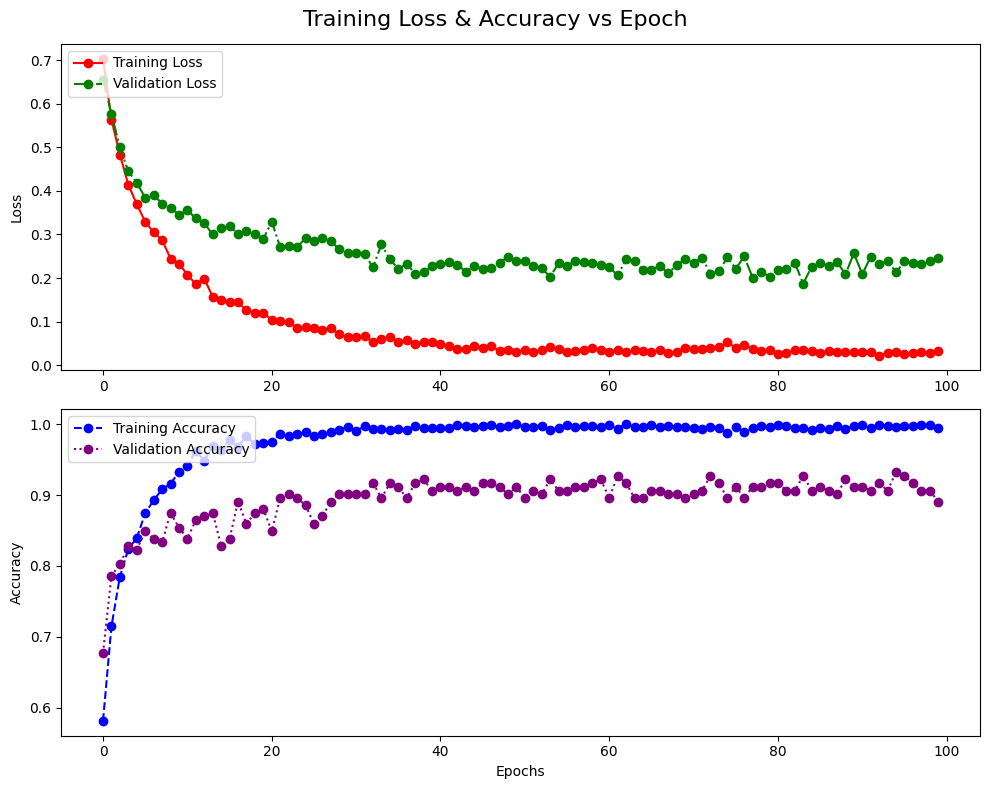

In [ ]:
epoch_log = [*range(epochs)]

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 filas, 1 columna

# Título y rotación del eje x
fig.suptitle("Training Loss & Accuracy vs Epoch", fontsize=16)
ax2.set_xlabel('Epochs')

# Crear las líneas para los datos de entrenamiento (colores y estilos personalizados)
ax1.plot(epoch_log, train_loss, color='red', linestyle='-', marker='o', label='Training Loss')
ax2.plot(epoch_log, train_accuracy, color='blue', linestyle='--', marker='o', label='Training Accuracy')

# Crear las líneas para los datos de validación (colores y estilos personalizados)
ax1.plot(epoch_log, val_loss, color='green', linestyle='-.', marker='o', label='Validation Loss')
ax2.plot(epoch_log, val_accuracy, color='purple', linestyle=':', marker='o', label='Validation Accuracy')

# Configurar ejes y leyendas para el primer subgráfico (pérdida)
ax1.set_ylabel('Loss', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Configurar ejes y leyendas para el segundo subgráfico (precisión)
ax2.set_ylabel('Accuracy', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

    # Nombre del archivo PDF
pdf_filename = "graficaFold2_Loss&AccvsEpoch.pdf"

    # Guardar la gráfica en un archivo PDF
plt.savefig(pdf_filename, format='pdf')

# Mostrar la gráfica
plt.show()

# **Evaluación del Modelo en el Conjunto de Prueba**

Este bloque de código realiza la evaluación final del modelo en el conjunto de prueba después de haber sido entrenado y seleccionado el mejor modelo.

1. **Inicialización del Modelo:**
   - Se carga y configura un modelo VGG16 con BatchNorm.
   - Se carga el estado del modelo previamente guardado (`mejor_modelo.pth`).

2. **Configuración para Evaluación:**
   - Se cambia el modelo al modo de evaluación (`model.eval()`).
   - Se inicializan variables para realizar un seguimiento de métricas como la precisión, y se crea una matriz de confusión.

3. **Bucle de Prueba:**
   - Se realiza un bucle sobre el conjunto de prueba (`test_loader`).
   - Se hacen predicciones sobre las imágenes de prueba.
   - Se calcula y actualiza la matriz de confusión.
   - Se acumulan las predicciones y etiquetas reales para cálculos posteriores.

4. **Cálculo de Métricas Finales:**
   - Se calcula la precisión, precisión, recall y F1-score utilizando las predicciones y etiquetas reales acumuladas.

Este bloque proporciona una evaluación completa del modelo en el conjunto de prueba y muestra métricas clave como precisión, recall y F1-score. La matriz de confusión también se utiliza para evaluar el rendimiento del modelo en cada clase. Estas métricas son fundamentales para comprender cómo se generaliza el modelo a datos no vistos y son esenciales para la evaluación del rendimiento del modelo en un problema de clasificación.

In [ ]:
# Inicializa listas para almacenar las predicciones y etiquetas reales
all_predictions = []
all_labels = []

model = models.vgg16_bn(pretrained=False)

# Modificar la capa de clasificación para dos clases y agregar BatchNorm
num_features = model.classifier[0].in_features

# Definir una nueva secuencia para la capa de clasificación con BatchNorm
classifier_with_bn = nn.Sequential(
    nn.Linear(num_features, 4096),  # Capa completamente conectada
    nn.ReLU(True),
    nn.Dropout(),
    nn.BatchNorm1d(4096),  # BatchNorm
    nn.Linear(4096, 4096),  # Capa completamente conectada
    nn.ReLU(True),
    nn.Dropout(),
    nn.BatchNorm1d(4096),  # BatchNorm
    nn.Linear(4096, 2)  # Capa de salida para dos clases
)

model.classifier = classifier_with_bn

model.load_state_dict(torch.load('mejor_modelo.pth'))

model.to(device)

# Cambiar el modelo a modo de evaluación
model.eval()

# Inicializa variables para las métricas
total_correct = 0
total_samples = 0

# Inicializa la matriz de confusión
confusion = torch.zeros(num_classes, num_classes)

# Realiza el bucle de prueba
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Realiza predicciones
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Calcula la matriz de confusión
        for t, p in zip(labels.view(-1), predictions.view(-1)):
            confusion[t.long(), p.long()] += 1

        # Calcula las métricas
        total_samples += labels.size(0)
        total_correct += (predictions == labels).sum().item()

        # Almacena las predicciones y etiquetas reales para cálculos posteriores
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcula métricas finales
print('Resultados con el mejor modelo')
accuracy = total_correct / total_samples
precision = precision_score(all_labels, all_predictions, average='micro')
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialia

Resultados con el mejor modelo


# **Impresión de Métricas y Matriz de Confusión**

Este bloque de código imprime las métricas obtenidas.

**Impresión de Métricas:**
   - Se imprime la precisión, precisión, recall y F1-score calculadas previamente.


In [ ]:
# Imprime las métricas y la matriz de confusión
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.9083333333333333
Precision: 0.9083333333333333
Recall: 0.9166666666666666
F1-Score: 0.9166666666666666


# **Generación y Guardado de Gráfico de Métricas**


Este bloque de código crea un gráfico de barras que visualiza las métricas de evaluación, como precisión, recall, F1-score, etc.

1. **Creación del Gráfico:**
   - Se crean barras para cada métrica con colores específicos.

2. **Etiquetas y Título:**
   - Se agrega una etiqueta al eje y y se establece un título para el gráfico.

3. **Guardado y Visualización:**
   - El gráfico se guarda en un archivo PDF.
   - Finalmente, se muestra el gráfico de barras.

Este tipo de gráfico proporciona una representación visual de las métricas de evaluación, lo que facilita la comparación entre ellas. Cada métrica tiene un color diferente para facilitar la identificación.

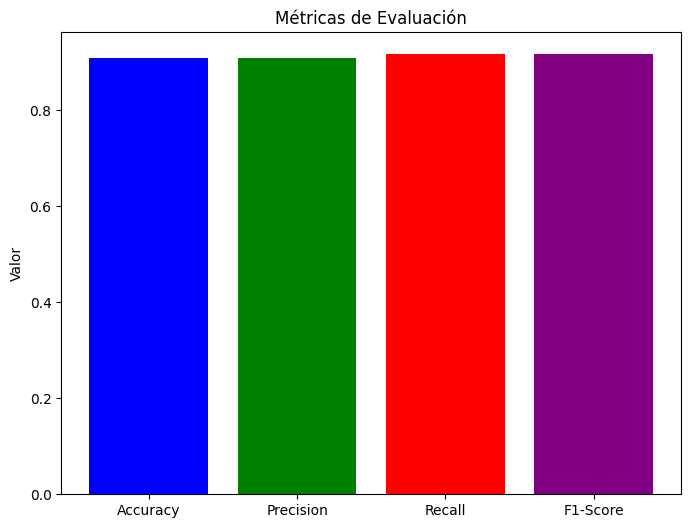

In [ ]:
# Valores de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Crea un gráfico de barras para las métricas
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

# Etiqueta del eje y
plt.ylabel('Valor')

# Título del gráfico
plt.title('Métricas de Evaluación')

    # Nombre del archivo PDF
pdf_filename2 = "graficaFold2_Metrics.pdf"

plt.savefig(pdf_filename2, format='pdf')

# Muestra el gráfico de barras
plt.show()

# **Generación y Guardado de Matriz de Confusión**

Este bloque de código crea y guarda una matriz de confusión visualizada como un mapa de calor utilizando Seaborn y Matplotlib.

1. **Creación de la Figura:**
   - Se crea una figura de Matplotlib con un tamaño específico.

2. **Conversión a DataFrame:**
   - La matriz de confusión se convierte en un DataFrame de pandas para facilitar la visualización.

3. **Mapa de Calor con Seaborn:**
   - Se utiliza Seaborn para crear un mapa de calor de la matriz de confusión.
   - Los valores de la matriz se muestran en cada celda del mapa de calor.

4. **Configuración de Etiquetas y Títulos:**
   - Se establecen etiquetas para los ejes x e y, así como un título para la matriz de confusión.

5. **Guardado y Visualización:**
   - La matriz de confusión visualizada se guarda en un archivo PDF.
   - Finalmente, se muestra la matriz de confusión.

Este tipo de visualización es útil para comprender el rendimiento del modelo en términos de la clasificación de las diferentes clases. Las celdas del mapa de calor muestran la cantidad de instancias que fueron clasificadas correctamente e incorrectamente para cada clase.

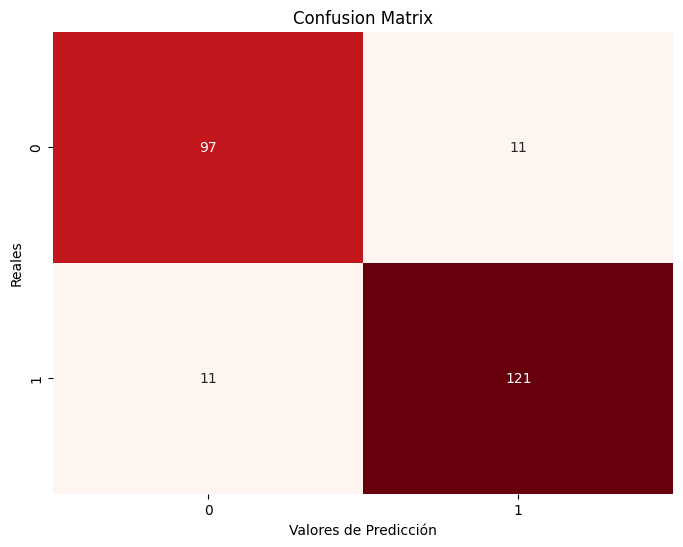

In [ ]:
# Crea una figura de Matplotlib
plt.figure(figsize=(8, 6))

# Convierte la matriz de confusión en un DataFrame de pandas para una mejor visualización
confusion_df = pd.DataFrame(confusion.numpy(), index=range(num_classes), columns=range(num_classes))

# Utiliza Seaborn para crear un mapa de calor
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Reds', cbar=False)

# Configura etiquetas y títulos
plt.xlabel('Valores de Predicción')
plt.ylabel('Reales')
plt.title('Confusion Matrix')

    # Nombre del archivo PDF
pdf_filename3 = "graficaFold2_Matrix.pdf"

plt.savefig(pdf_filename3, format='pdf')

# Muestra la matriz de confusión
plt.show()